# Differential methylation of neutrophil cohort

In [1]:
cd ..

/cellar/users/agross/TCGA_Code/Methlation


In [2]:
import NotebookImport
from Setup.Imports import *

import Setup.DX_Imports as dx
import Parallel.Age_HIV_Features as fx
import statsmodels.api as sm

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


importing IPython notebook from Setup/DX_Imports

importing IPython notebook from Parallel/Age_HIV_Features

importing IPython notebook from HIV_Age_Advancement

importing IPython notebook from Setup/MethylationAgeModels

importing IPython notebook from Setup/Read_HIV_Data

### Read in Validation Data

In [3]:
path = '/cellar/users/agross/TCGA_Code/Methlation/data/Validation/'

In [4]:
df_hiv =  pd.read_csv(path + 'betas_BMIQ.csv', index_col=0)

#### Read in annotations 

In [5]:
hiv_ann = pd.read_excel(path + 'Methylome human NEUvs WB.xlsx', 
                        sheetname='HIV', skiprows=2, index_col=0)
control_ann = pd.read_excel(path + 'Methylome human NEUvs WB.xlsx',
                            sheetname='Negative', skiprows=2, index_col=0)
ann = pd.concat([hiv_ann, control_ann], keys=['HIV+','HIV-'])
ann = ann.reset_index()
ann = ann.rename(columns={'Age (years)': 'age', 'level_0':'HIV'})
ann = ann.set_index('PATID')
ann = ann.ix[df_hiv.columns]

In [6]:
hiv = ann.HIV == 'HIV+'
intercept = pd.Series(1, index=hiv.index)
age = ann.age

X = pd.concat([intercept, hiv, age], axis=1, 
              keys=['Intercept','HIV', 'age'])
X_reduced = X[['Intercept','age']]

w = (len(hiv) - hiv.map(hiv.value_counts())).astype(float) / len(hiv)
w = w.ix[X.index]

X = X.ix[df_hiv.columns]

In [7]:
%%time
path = '/cellar/users/agross/TCGA_Code/Methlation/data/Validation/'

if False:
    p = {}
    d_hiv = {}

    for i,y in df_hiv.iterrows():
        y.name = 'marker'
        y = logit_adj(y)
        mod_all = sm.WLS(y, X, weights=w)
        res_ref = mod_all.fit()
        p[i] = res_ref.params

        mod_reduced = sm.WLS(y, X_reduced, weights=w)
        m1 = mod_reduced.fit()
        d_hiv[i] = res_ref.compare_lr_test(m1)

    p = pd.DataFrame(p).T
    d_hiv = pd.DataFrame(d_hiv, index=['LR','p','df']).T
    
    models = pd.concat([p, d_hiv], keys=['model','drop1'], axis=1)
    models.to_csv(path + 'neu_mv_models.csv')

else:
    models = pd.read_csv(path + 'neu_mv_models.csv', index_col=0,
                         header=[0,1])

CPU times: user 711 ms, sys: 47.6 ms, total: 759 ms
Wall time: 2.34 s


In [8]:
#from Setup.Read_HIV_Data import *

In [9]:
ann = dx.probe_annotations.sort(['Chromosome','Genomic_Coordinate'])

In [10]:
mm = df_hiv.mean(1)

In [11]:
monocyte_corr = pd.read_csv('/cellar/users/agross/Data/Methylation_Controls/monocyte_age_corr.csv',
                            index_col=0, squeeze=True)
cd4_corr = pd.read_csv('/cellar/users/agross/Data/Methylation_Controls/CD4T_age_corr.csv',
                            index_col=0, squeeze=True)
neu_corr = pd.read_csv('/cellar/users/agross/Data/Methylation_Controls/neutrophils_age_corr.csv',
                            index_col=0, squeeze=True)
beta_corr = pd.read_csv('/cellar/users/agross/Data/Methylation_Controls/Beta_age_corr.csv',
                            index_col=0, squeeze=True)

In [12]:
dd = fx.r4.multi_variate.HIV > 0
dd.name = 'up'
hiv_dx = fx.g_hiv
hiv_dx.name = 'hiv'

dx_hiv = combine(hiv_dx, dd).replace({'up':'neither','hiv':'hiv_down', 'both':'hiv_up'})
dx_hiv.value_counts()

neither     391683
hiv_down     46220
hiv_up       35141
dtype: int64

In [13]:
dx_gran = bhCorrection(models.drop1.p) < .1
dx_gran.value_counts()

False    416920
True      68592
dtype: int64

In [14]:
dd = models.model.HIV > 0
dd.name = 'up'
hiv_dx_gran = dx_gran
hiv_dx_gran.name = 'hiv'

hiv_dx_gran = combine(hiv_dx_gran, dd).replace({'up':'neither','hiv':'hiv_down', 'both':'hiv_up'})
hiv_dx_gran.value_counts()

neither     416920
hiv_up       38332
hiv_down     30260
dtype: int64

In [15]:
or_ct = pd.DataFrame({a:{b:odds_ratio(dx_hiv==a, hiv_dx_gran==b) 
                         for b in hiv_dx_gran.unique()}
                      for a in dx_hiv.unique()}).T
or_ct = or_ct.ix[['hiv_down','neither','hiv_up'],
                 ['hiv_down','neither','hiv_up']]
or_ct.columns.name = None
or_ct.index.name = None
or_ct

,hiv_down,neither,hiv_up
hiv_down,2.55,0.83,0.37
neither,0.64,2.06,0.44
hiv_up,0.45,0.33,5.74


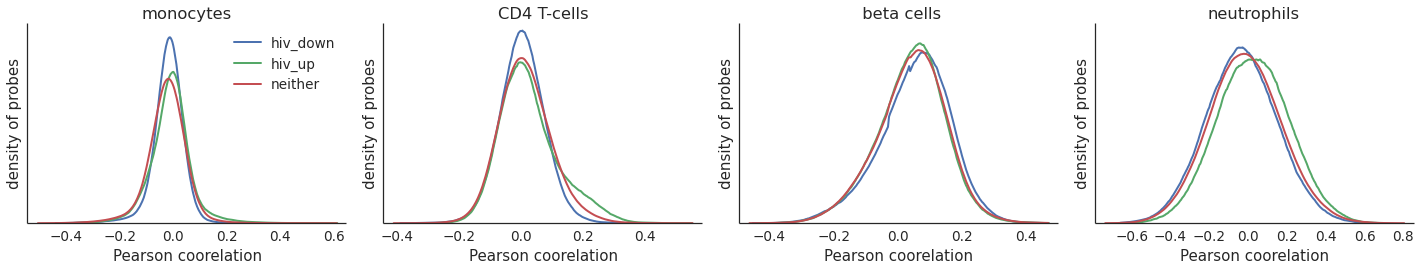

In [16]:
fig, axs = subplots(1,4, figsize=(20,4))
draw_dist(monocyte_corr, dx_hiv, ax=axs[0])
draw_dist(cd4_corr, dx_hiv, ax=axs[1])
draw_dist(beta_corr.clip(-.5,.5), dx_hiv, ax=axs[2])
draw_dist(neu_corr, dx_hiv, ax=axs[3])
labels = ['monocytes','CD4 T-cells',' beta cells', 'neutrophils']
for i,ax in enumerate(axs):
    ax.set_title(labels[i])
    ax.set_xlabel('Pearson coorelation')
    prettify_ax(ax)
    ax.set_ylabel('density of probes')
    ax.set_yticks([])
    ax.legend_.set_visible(False)
axs[0].legend(loc='upper right')
fig.tight_layout()

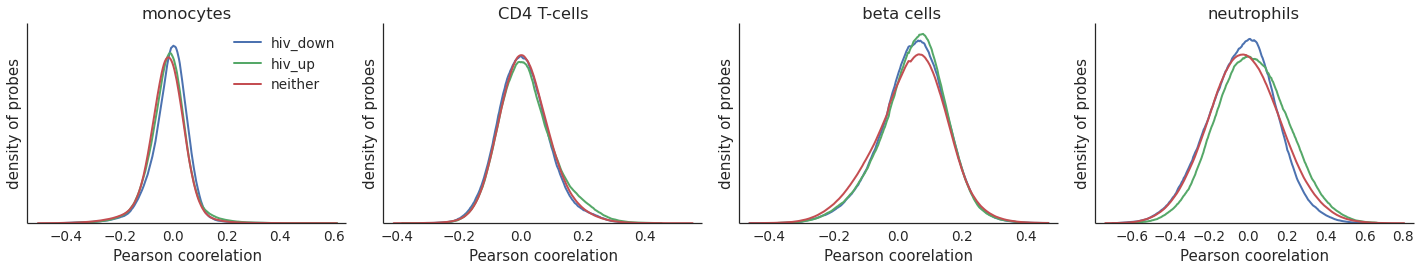

In [17]:
fig, axs = subplots(1,4, figsize=(20,4))
draw_dist(monocyte_corr, hiv_dx_gran, ax=axs[0])
draw_dist(cd4_corr, hiv_dx_gran, ax=axs[1])
draw_dist(beta_corr.clip(-.5,.5), hiv_dx_gran, ax=axs[2])
draw_dist(neu_corr, hiv_dx_gran, ax=axs[3])
labels = ['monocytes','CD4 T-cells',' beta cells', 'neutrophils']
for i,ax in enumerate(axs):
    ax.set_title(labels[i])
    ax.set_xlabel('Pearson coorelation')
    prettify_ax(ax)
    ax.set_ylabel('density of probes')
    ax.set_yticks([])
    ax.legend_.set_visible(False)
axs[0].legend(loc='upper right')
fig.tight_layout()

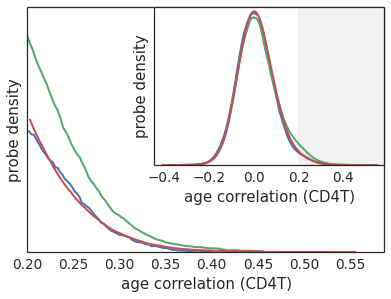

In [98]:
cd4_corr.name = 'age correlation (CD4T)'
draw_dist(cd4_corr, hiv_dx_gran, lim=.2, inset=True, legend=False)

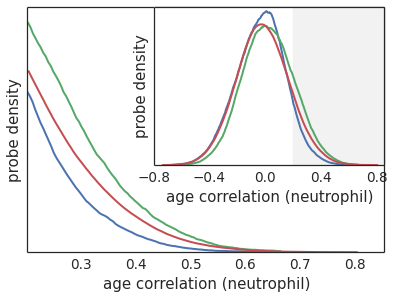

In [73]:
monocyte_corr.name = 'age correlation (monocytes)'
draw_dist(neu_corr, hiv_dx_gran, lim=.2, inset=True, legend=False)
plt.gca().set_xticks([-.8, -.4, 0, .4, .8]);

In [20]:
two_hit = (dx_hiv == 'hiv_up') & (hiv_dx_gran == 'hiv_up')
tt = two_hit.groupby(ann.Gene_Symbol).agg([np.mean, np.sum, 
                                           pd.Series.count])
tt[tt['sum'] > 3].sort(['mean','count']).tail()

,mean,sum,count
Gene_Symbol,,,
PLEKHG4,0.37,7,19
LOC400927,0.38,6,16
BOLA3,0.38,5,13
ZNF768,0.38,5,13
C11orf68;DRAP1,0.50,4,8


In [21]:
two_hit = (dx_hiv == 'hiv_down') & (hiv_dx_gran == 'hiv_down')
tt = two_hit.groupby(ann.Gene_Symbol).agg([np.mean, np.sum, 
                                           pd.Series.count])
tt[tt['sum'] > 3].sort(['mean','count']).tail()

,mean,sum,count
Gene_Symbol,,,
L3MBTL,0.22,7,32
HCP5,0.29,6,21
IFI44L,0.57,4,7
TMEM49,0.75,6,8
TRIM69,1.00,6,6


In [22]:
pd.crosstab(dx_hiv == 'hiv_down', ann.Gene_Symbol == 'HCP5')

Gene_Symbol,False,True
row_0,,
False,426813,11
True,46210,10


In [23]:
pd.crosstab(hiv_dx_gran == 'hiv_down', ann.Gene_Symbol == 'HCP5')

Gene_Symbol,False,True
row_0,,
False,455238,14
True,30253,7


In [24]:
fisher_exact_test(two_hit, ann.Gene_Symbol == 'TRIM69')

odds_ratio         inf
p             4.39e-12
dtype: float64

In [25]:
fisher_exact_test(two_hit, ann.Gene_Symbol == 'HCP5')

odds_ratio    3.09e+01
p             2.02e-07
dtype: float64

In [26]:
gwas = pd.read_csv('./data/Euro_CHAVI_Setpoint_liftover.csv', index_col=0)
gwas.chromosome = gwas.chromosome.astype(str)

In [27]:
gwas.query('chromosome == "6" &  start > (31431780 - 5000) &  start < (31431780 + 2000)')

,chromosome,end,start,Map,-logP
241714,6,31432125,31432125,31432125,4.28
250862,6,31431780,31431780,31431780,11.03
261605,6,31428967,31428967,31428967,1.12


In [28]:
keepers = fx.pred_c.index.intersection(ti(fx.hiv == 'HIV+'))
v = np.log2(fx.labs['CD4/CD8 ratio']).dropna()
df = fx.df_hiv.ix[:, keepers]
df = df.sub(df.mean(1), axis=0).div(df.std(1), axis=0)
#rr = screen_feature(v.ix[keepers], spearman_pandas, df)

In [29]:
rr = df.ix[:, v.index].T.corrwith(v)

In [30]:
hcp5 = ti(ann.Gene_Symbol == 'HCP5')
rr.rank(ascending=False).ix[hcp5].order().head()

Composite Element REF
cg01082299      32
cg00218406      53
cg23232773     133
cg25843003    1268
cg18808777    3877
dtype: float64

In [115]:
min_c = ann.Genomic_Coordinate.ix[hcp5].min()
max_c = ann.Genomic_Coordinate.ix[hcp5].max()
w = 100
i = ann.query('Chromosome == "6" & (Genomic_Coordinate > (@min_c - @w)) & (Genomic_Coordinate < (@max_c + @w))')
hcp5 = i.index

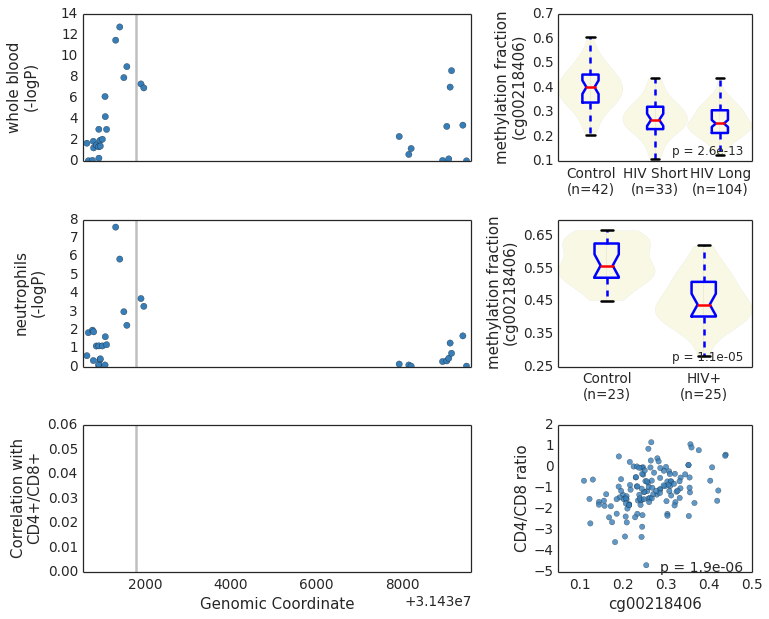

In [116]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(12,10))
gs1 = gridspec.GridSpec(3, 2, width_ratios=[4,2], hspace=.4, wspace=.3)
axs = [plt.subplot(gs1[i]) for i in range(6)]

series_scatter(ann.Genomic_Coordinate, 
               -1*np.log10(fx.r4.HIV_LR.p.ix[hcp5]),
               s=40, color=colors[1], alpha=1, edgecolor='black',
               ax=axs[0], ann=None)
series_scatter(ann.Genomic_Coordinate,
               -1*np.log10(models.drop1.p.ix[hcp5]),
               s=40, color=colors[1], alpha=1, edgecolor='black',
               ax=axs[2], ann=None)
series_scatter(ann.Genomic_Coordinate, 
              rr.ix[hcp5], s=40, color=colors[1], alpha=1, edgecolor='black',
              ax=axs[4], ann=None)

for ax in [axs[0], axs[2], axs[4]]:
    ax.axvline(31431780, color='grey', alpha=.5)
    ax.set_xbound(ann.Genomic_Coordinate.ix[hcp5].min() - 100,
                  ann.Genomic_Coordinate.ix[hcp5].max() + 100)
    ax.set_xlabel('')
    ax.set_ybound(0)
axs[0].set_xticks([])
axs[2].set_xticks([])
axs[0].set_ylabel('whole blood\n(-logP)\n')
axs[2].set_ylabel('neutrophils\n(-logP)\n')
axs[4].set_ylabel('Correlation with\nCD4+/CD8+')
axs[4].set_xlabel('Genomic Coordinate')


violin_plot_pandas(fx.duration, fx.df_hiv.ix['cg00218406'],
                   order=['Control','HIV Short','HIV Long'], ax=axs[1])
violin_plot_pandas(hiv.map({False: 'Control',True:'HIV+'}), df_hiv.ix['cg00218406'], 
                   ax=axs[3], order=['Control','HIV+'])
series_scatter(fx.df_hiv.ix['cg00218406'].ix[keepers], 
               np.log2(fx.labs['CD4/CD8 ratio']).dropna(),
               s=30, color=colors[1], alpha=.8, edgecolor='black',
               ax=axs[5])
for ax in [axs[1], axs[3]]:
    ax.set_xlabel('')
    ax.set_ylabel('methylation fraction \n({})'.format(ax.get_ylabel()))
    
axs[3].set_yticks([.25,.35,.45,.55,.65])
axs[5].set_xticks([.1,.2,.3,.4,.5])
fig.tight_layout()

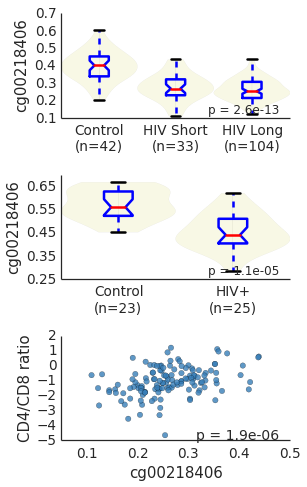

In [42]:
fig, axs = subplots(3,1, figsize=(4.5,7))
violin_plot_pandas(fx.duration, fx.df_hiv.ix['cg00218406'],
                   order=['Control','HIV Short','HIV Long'], ax=axs[0])
violin_plot_pandas(hiv.map({False: 'Control',True:'HIV+'}), df_hiv.ix['cg00218406'], 
                   ax=axs[1], order=['Control','HIV+'])
series_scatter(fx.df_hiv.ix['cg00218406'].ix[keepers], 
               np.log2(fx.labs['CD4/CD8 ratio']).dropna(),
               s=30, color=colors[1], alpha=.8, edgecolor='black',
               ax=axs[2])
axs[1].set_yticks([.25,.35,.45,.55,.65])
axs[2].set_xticks([.1,.2,.3,.4,.5])

for ax in axs:
    prettify_ax(ax)
    ax.set_xlabel('')
axs[2].set_xlabel('cg00218406')
fig.tight_layout()

In [34]:
models.ix[ti(ann.Gene_Symbol == 'HCP5')].sort([('drop1','p')]).head()

model                  drop1             
                      Intercept   HIV       age     LR         p df
Composite Element REF                                              
cg25843003                -0.34 -0.60 -9.84e-03  31.05  2.51e-08  1
cg00218406                 0.52 -0.45 -5.52e-03  23.30  1.38e-06  1
cg23232773                 0.99 -0.27 -1.30e-03  13.87  1.96e-04  1
cg01082299                 0.76 -0.22 -1.05e-03  12.04  5.20e-04  1
cg18808777                -0.62 -0.24 -4.39e-03  10.79  1.02e-03  1

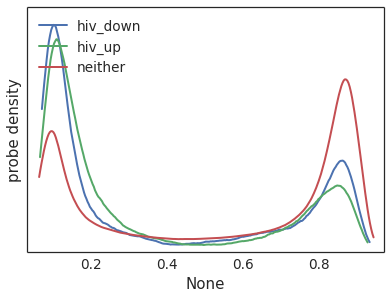

In [110]:
draw_dist(mm, hiv_dx_gran)

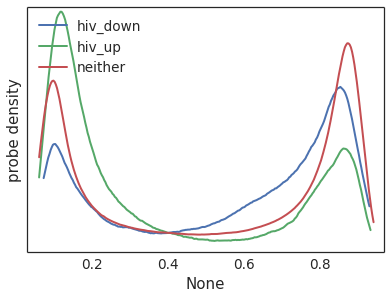

In [107]:
draw_dist(fx.mm, dx_hiv)

In [100]:
dd = (dx_hiv == 'hiv_down') & (fx.mm < .5) & (fx.g_age == False)
dd = dd.ix[fx.probe_idx].ix[ann.index].dropna()
m = dd.mean()
w = 200
t = lambda s: sp.stats.binom_test(s, w, p=m)
v = pd.concat([pd.rolling_mean(s, w, center=True) for i,s in 
               dd.groupby(ann.Chromosome)])
lookup = pd.Series({i: t(i) for i in (v.dropna() * w).unique()})
biom_p = (v.dropna() * w).map(lookup).order()

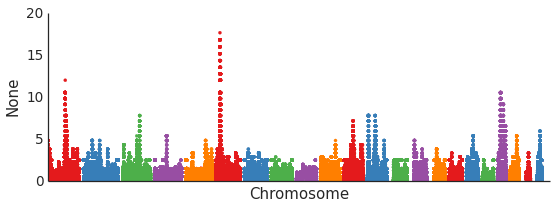

In [101]:
manhattan(-1*np.log10(biom_p), ann.Chromosome, ann.Genomic_Coordinate,
          ybound=[0,20], ticks=False)

In [90]:
mm = df_hiv.mean(1)

In [93]:
dd = (hiv_dx_gran == 'hiv_down') & (mm < .5) & (neu_corr > -.2)
dd = dd.ix[fx.probe_idx].ix[ann.index].dropna()
m = dd.mean()
w = 200
t = lambda s: sp.stats.binom_test(s, w, p=m)
v = pd.concat([pd.rolling_mean(s, w, center=True) for i,s in 
               dd.groupby(ann.Chromosome)])
lookup = pd.Series({i: t(i) for i in (v.dropna() * w).unique()})
biom_p_gran = (v.dropna() * w).map(lookup).order()

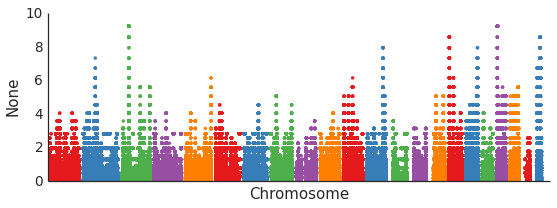

In [94]:
manhattan(-1*np.log10(biom_p_gran), ann.Chromosome, ann.Genomic_Coordinate,
          ybound=[0,10], ticks=False)

In [95]:
dd = (hiv_dx_gran == 'hiv_up') & (mm > .5) & (neu_corr < .2)
dd = dd.ix[fx.probe_idx].ix[ann.index].dropna()
m = dd.mean()
w = 200
t = lambda s: sp.stats.binom_test(s, w, p=m)
v = pd.concat([pd.rolling_mean(s, w, center=True) for i,s in 
               dd.groupby(ann.Chromosome)])
lookup = pd.Series({i: t(i) for i in (v.dropna() * w).unique()})
biom_p_gran = (v.dropna() * w).map(lookup).order()

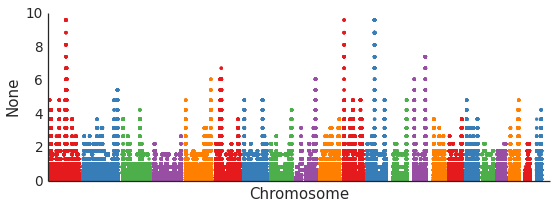

In [96]:
manhattan(-1*np.log10(biom_p_gran), ann.Chromosome, ann.Genomic_Coordinate,
          ybound=[0,10], ticks=False)

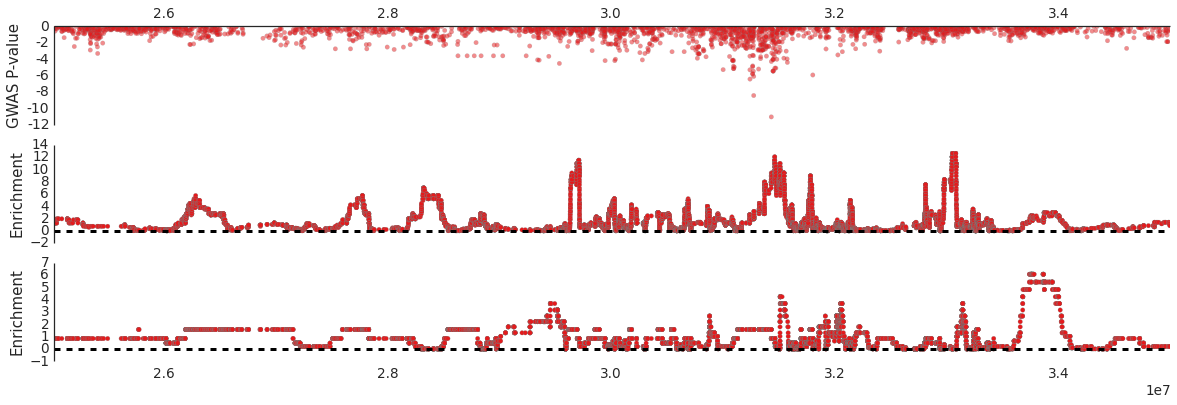

In [97]:
fig, axs  = subplots(3,1, figsize=(20,6), sharex=True)

ax=axs[0]
k = ti((gwas.chromosome == '6') & 
       gwas.Map.isin(range(25000000, 35000000)))
x = gwas.Map.ix[k]
rr = -1*gwas['-logP']

series_scatter(x, rr, color=colors[0],
               s=20, ax=ax, ann=None,
               edgecolor='grey')

ax.set_ylabel('GWAS P-value')
ax.set_yticks(range(-12, 1, 2))
ax.set_yticklabels(range(-12, 1, 2), size=14)
ax.set_ylim(-12,0)
ax.set_xlabel('')
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax, top=True)

k = ti((ann.Chromosome == '6') & 
       ann.Genomic_Coordinate.isin(range(25000000, 35000000)))
x = ann.Genomic_Coordinate.ix[k].order()

ax = axs[1]

series_scatter(x, -1*np.log10(biom_p).ix[x.index], s=20, ann=None, color=colors[0],
               edgecolor='grey', ax=ax, alpha=1)

ax.axhline(0, ls='--', color='black', lw=3)
ax.set_ylabel('Enrichment')
ax.spines['bottom'].set_visible(False)
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax)
ax.set_xlabel('')

ax = axs[2]

series_scatter(x, -1*np.log10(biom_p_gran).ix[x.index], s=20, ann=None, color=colors[0],
               edgecolor='grey', ax=ax, alpha=1)

ax.axhline(0, ls='--', color='black', lw=3)
ax.set_ylabel('Enrichment')
ax.spines['bottom'].set_visible(False)
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax)
ax.set_xlabel('')

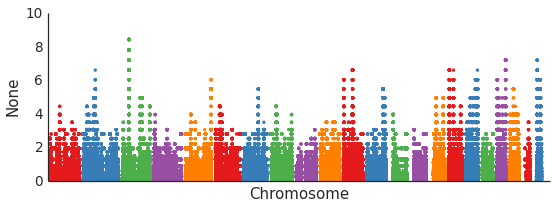

In [42]:
manhattan(-1*np.log10(biom_p_gran), ann.Chromosome, ann.Genomic_Coordinate,
          ybound=[0,10], ticks=False)

In [43]:
full_region = ((ann.Chromosome == '6') & 
                   ann.Genomic_Coordinate.isin(range(25000000, 35000000)))
histone_region = ((ann.Chromosome == '6') & 
                   ann.Genomic_Coordinate.isin(range(25000000, 29570008)))
hla_region = ((ann.Chromosome == '6') & 
              ann.Genomic_Coordinate.isin(range(29570008, 33377112)))

In [44]:
fisher_exact_test(dx_hiv == 'hiv_down', hla_region)

odds_ratio    1.35e+00
p             1.62e-22
dtype: float64

In [45]:
fisher_exact_test(dx_hiv == 'hiv_down', full_region)

odds_ratio    1.33e+00
p             3.13e-26
dtype: float64

In [46]:
fisher_exact_test(hiv_dx_gran == 'hiv_up', hla_region)

odds_ratio    8.37e-01
p             2.71e-06
dtype: float64

In [47]:
tt = dx.ttest_df(hiv, df_hiv)

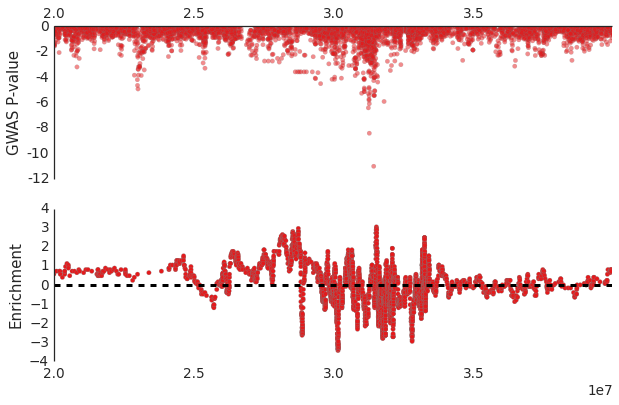

In [48]:
fig, axs  = subplots(2,1, figsize=(10,6), sharex=True)

ax=axs[0]
k = ti((gwas.chromosome == '6') & 
       gwas.Map.isin(range(20000000, 40000000)))
x = gwas.Map.ix[k]
rr = -1*gwas['-logP']

series_scatter(x, rr, color=colors[0],
               s=20, ax=ax, ann=None,
               edgecolor='grey')

ax.set_ylabel('GWAS P-value')
ax.set_yticks(range(-12, 1, 2))
ax.set_yticklabels(range(-12, 1, 2), size=14)
ax.set_ylim(-12,0)
ax.set_xlabel('')
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax, top=True)

k = ti((ann.Chromosome == '6') & 
       ann.Genomic_Coordinate.isin(range(20000000, 40000000)))
x = ann.Genomic_Coordinate.ix[k].order()

ax = axs[1]

d = (tt[tt.abs() > 0] > 0).ix[ann.index].dropna()
v = pd.concat([pd.rolling_mean(s, 200, center=True) for i,s in 
               d.groupby(ann.Chromosome)])
v = (v - v.mean()) / v.std()

series_scatter(x[::5], v.ix[x.index], s=20, ann=None, color=colors[0],
               edgecolor='grey', ax=ax, alpha=1)

ax.axhline(0, ls='--', color='black', lw=3)
ax.set_ylabel('Enrichment')
ax.spines['bottom'].set_visible(False)
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax)
ax.set_xlabel('')

In [49]:
f2 = {'gran-up': (hiv_dx_gran=='hiv_up') & (dx_hiv != 'age-up'), 
      'gran-down': (hiv_dx_gran=='hiv_down') & (dx_hiv != 'hiv_down'),
      'blood-up': (dx_hiv=='hiv_up') & (hiv_dx_gran != 'hiv_up'), 
      'blood-down': (dx_hiv=='hiv_down') & (hiv_dx_gran != 'hiv_down'),
      'both-up': (hiv_dx_gran=='hiv_up') & (dx_hiv=='hiv_up'),
      'both-down': (hiv_dx_gran=='hiv_down') & (dx_hiv=='hiv_down')}
probes_sets = {'PRC2': dx.prc2_probes, 'CpG island': dx.cpg_island,
               'DHS': dx.dhs_site, 'Enhancer': dx.enhancer,
               'Gene body': dx.gene_body, 'TSS': dx.gene_tss,
               'Promoter': dx.promoter}

In [50]:
associations = {}
for i,a in f2.iteritems():
    for j,b in probes_sets.iteritems():
        associations[(i,j)] = odds_ratio(a,b.ix[fx.probe_idx])
associations = pd.Series(associations)

In [51]:
o = ['DHS','PRC2','CpG island','Enhancer', 'TSS','Gene body','Promoter']
p = ['gran-up','both-up', 'blood-up']
df1 = associations.unstack().T.ix[o[::-1],p]

o = ['DHS','PRC2','CpG island','Enhancer', 'TSS','Gene body','Promoter']
p = ['gran-down','both-down', 'blood-down']
df2 = associations.unstack().T.ix[o[::-1],p]

In [52]:
cc = sns.color_palette()

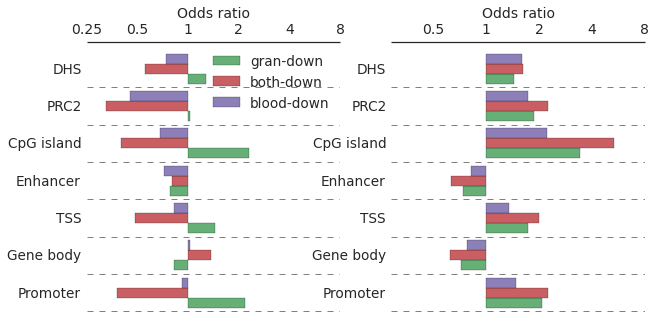

In [53]:
fig, axs = subplots(1,2, figsize=(10,5))
ax=axs[1]
ax.xaxis.tick_top()
np.log2(df1).plot(kind='barh', ax=ax, alpha=.9, width=.8, 
                               color=[cc[1],  cc[2], cc[3]])
ax.set_xticks([-3, -2,-1,0,1,2,3,4])
ax.set_xticklabels([.125, .25,.5,1,2,4,8,16], size=14)
ax.set_xbound(-1.8, 3.)
ax.set_ylim(-.75, 6.72)
ax.set_xlabel('Odds ratio', size=14)
ax.xaxis.set_label_position('top') 
ax.legend().set_visible(False)
ax.spines['left'].set_visible(False)
#ax.set_yticklabels(o[::-1], x=.1)
for i in range(len(o)):
    ax.axhline(i-.5, color='grey', ls='--', lw=1)
#ax.legend()
prettify_ax(ax, top=True)

ax=axs[0]
ax.xaxis.tick_top()
np.log2(df2).plot(kind='barh', ax=ax, alpha=.9, width=.8, 
                               color=[cc[1],  cc[2], cc[3]])
ax.set_xticks([-3, -2,-1,0,1,2,3,4])
ax.set_xticklabels([.125, .25,.5,1,2,4,8,16], size=14)
ax.set_xbound(-2, 3.)
ax.set_ylim(-.75, 6.72)
ax.set_xlabel('Odds ratio', size=14)
ax.xaxis.set_label_position('top') 
ax.legend().set_visible(False)
ax.spines['left'].set_visible(False)
#ax.set_yticklabels(o[::-1], x=.1)
for i in range(len(o)):
    ax.axhline(i-.5, color='grey', ls='--', lw=1)
ax.legend()
prettify_ax(ax, top=True)